In [6]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import s3fs
os.environ['PROJ_LIB'] = '/anaconda3/pkgs/proj4-5.2.0-h1de35cc_1001/share/proj'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

### Load data

In [17]:
df_wt = pd.read_csv('windturbines.csv', index_col=0)

In [8]:
fs_s3 = s3fs.S3FileSystem(anon=True)
s3path = 'greenlytics-public/forecasting-competition/releases/Task4/07/20010729T00Z.nc'
remote_file_obj = fs_s3.open(s3path, mode='rb')
ds = xr.open_dataset(remote_file_obj, engine='h5netcdf')

In [10]:
ds

<xarray.Dataset>
Dimensions:           (ensemble_member: 10, time: 24, x: 71, y: 169)
Coordinates:
    latitude          (y, x) float64 ...
  * time              (time) datetime64[ns] 2001-07-29 ... 2001-07-29T23:00:00
  * y                 (y) float32 -879330.6 -869330.6 ... 790669.4 800669.4
  * x                 (x) float32 -322485.4 -312485.4 ... 367514.6 377514.6
    longitude         (y, x) float64 9.984 10.14 10.29 ... 24.33 24.59 24.85
  * ensemble_member   (ensemble_member) int16 0 1 2 3 4 5 6 7 8 9
Data variables:
    Temperature       (time, ensemble_member, y, x) float32 ...
    RelativeHumidity  (time, ensemble_member, y, x) float32 ...
    Wind_U            (time, ensemble_member, y, x) float32 ...
    Wind_V            (time, ensemble_member, y, x) float32 ...
    Pressure          (time, ensemble_member, y, x) float32 ...
    CloudCover        (time, ensemble_member, y, x) float32 ...
    WindGustSpeed     (time, ensemble_member, y, x) float32 ...
Attributes:
    resolution:  10.0km

In [9]:
ds.longitude.mean().values

array(15.54849072)

In [123]:
ds.x[0].values

array(-322485.4, dtype=float32)

In [124]:
ds.x[-1].values

array(377514.6, dtype=float32)

In [120]:
ds.y[0].values

array(-879330.6, dtype=float32)

In [121]:
ds.y[-1].values

array(800669.4, dtype=float32)

### Plot NWP data and wind turbines

In [128]:
def create_map(lon_0, lat_0, earth_radius):
    m = Basemap(llcrnrlon=ds.longitude.min()+1,
                llcrnrlat=ds.latitude.min(),
                urcrnrlon=ds.longitude.max()+3,
                urcrnrlat=ds.latitude.max()+0.5,
                projection='lcc',
                rsphere=earth_radius,
                lat_0=lat_0, 
                lon_0=lon_0)
    
    return m

lon_0 = 15.0
lat_0 = 63.0
earth_radius = 6371000.0
m = create_map(lon_0, lat_0, earth_radius)
x0, y0 = m(lon_0, lat_0)

In [129]:
y0

868936.400859174

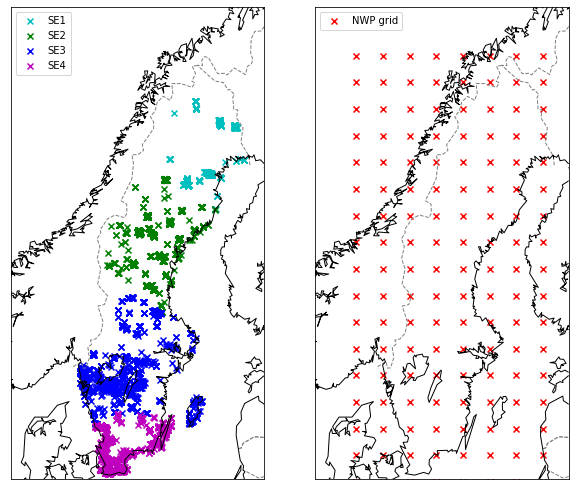

In [130]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(121)
m = Basemap(llcrnrlon=ds.longitude.min()+1,
            llcrnrlat=ds.latitude.min(),
            urcrnrlon=ds.longitude.max()+3,
            urcrnrlat=ds.latitude.max()+0.5,
            resolution='l',
            projection='lcc',
            lat_0=lat_0,
            lon_0=lon_0)

for price_region, col in zip(['SE1', 'SE2', 'SE3', 'SE4'], ['c', 'g', 'b', 'm']):
    m.scatter(df_wt[df_wt['Price region'] == price_region]['Longitude'].values,
              df_wt[df_wt['Price region'] == price_region]['Latitude'].values,
              latlon=True, marker='x', color=col, label=price_region) 

m.drawcountries(linewidth=1, linestyle='dashed', color='gray')
m.drawcoastlines()
plt.legend(loc='upper left')

ax = fig.add_subplot(122)
m = Basemap(llcrnrlon=ds.longitude.min()+1,
            llcrnrlat=ds.latitude.min(),
            urcrnrlon=ds.longitude.max()+3,
            urcrnrlat=ds.latitude.max()+0.5,
            resolution='l',
            projection='lcc',
            lat_0=lat_0,
            lon_0=lon_0)
m.scatter(ds.longitude.values[::10,::10], ds.latitude.values[::10,::10], latlon=True, marker='x', color='r', label='NWP grid') 
m.drawcountries(linewidth=1, linestyle='dashed', color='gray')
m.drawcoastlines()
plt.legend(loc='upper left')

plt.show()

## With pyproj

In [131]:
import pyproj
proj4 = '+proj=lcc +lon_0=15.0 +lat_0=63.0 +lat_1=63.0 +R=6371000.0'
p = pyproj.Proj(proj4)
x, y = p(df_wt['Longitude'].values,
         df_wt['Latitude'].values,
         inverse=False)


In [138]:
df_wt['x'] = x+x0
df_wt['y'] = y+y0

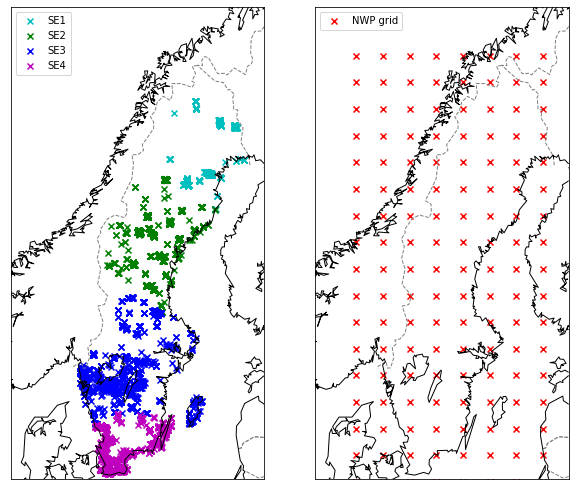

In [140]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(121)
m = Basemap(llcrnrlon=ds.longitude.min()+1,
            llcrnrlat=ds.latitude.min(),
            urcrnrlon=ds.longitude.max()+3,
            urcrnrlat=ds.latitude.max()+0.5,
            resolution='l',
            projection='lcc',
            lat_0=lat_0,
            lon_0=lon_0)

for price_region, col in zip(['SE1', 'SE2', 'SE3', 'SE4'], ['c', 'g', 'b', 'm']):
    m.scatter(df_wt[df_wt['Price region'] == price_region]['x'].values,
              df_wt[df_wt['Price region'] == price_region]['y'].values,
              latlon=False, marker='x', color=col, label=price_region) 

m.drawcountries(linewidth=1, linestyle='dashed', color='gray')
m.drawcoastlines()
plt.legend(loc='upper left')

ax = fig.add_subplot(122)
m = Basemap(llcrnrlon=ds.longitude.min()+1,
            llcrnrlat=ds.latitude.min(),
            urcrnrlon=ds.longitude.max()+3,
            urcrnrlat=ds.latitude.max()+0.5,
            resolution='l',
            projection='lcc',
            lat_0=lat_0,
            lon_0=lon_0)
m.scatter(ds.longitude.values[::10,::10], ds.latitude.values[::10,::10], latlon=True, marker='x', color='r', label='NWP grid') 
m.drawcountries(linewidth=1, linestyle='dashed', color='gray')
m.drawcoastlines()
plt.legend(loc='upper left')

plt.show()